# Quantum Integer Programming and Quantum Machine Learning 47-779/785, Tepper School of Business.
# Introduction to Quantum Computing 18-819F, Electrical and Computers Engineering.
# Fall 2021, Carnegie Mellon University

This notebook contains material from the Quantum Integer Programming and Quantum Machine Learning Course at CMU Fall 2021 by David Bernal (bernalde at cmu.edu), Sridhar Tayur (stayur at cmu.edu), Elias Towe (towe at cmu.edu), and Davide Venturelli; the content is available on **[Github](https://github.com/bernalde/QuIPML)**.
The text is released under the **[CC-BY-NC-ND-4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode) license, and code is released under the **[MIT license](https://opensource.org/licenses/MIT).*

Run in **[Google Colab](https://colab.research.google.com/github/bernalde/QuIPML/blob/main/notebooks/Notebook%202%20-%20QUBO%20and%20Ising.ipynb)**

## Quadratic Unconstrained Binary Optimization
This notebook will explain the basics of the QUBO modeling. In order to implement the different QUBOs we will use D-Wave's packages **[dimod](https://github.com/dwavesystems/dimod)**, and then solve them using **[neal](https://github.com/dwavesystems/dwave-neal)**'s implementation of simulated annealing.
We will also leverage the use of D-Wave's package **[dwavebinarycsp](https://github.com/dwavesystems/dwavebinarycsp)** to translate constraint satisfaction problems to QUBOs. Finally, for we will use **[Networkx](https://networkx.github.io/)** for network models/graphs.

#### Problem statement
We define a QUBO as the following optimization problem:
$$
\min_{x \in \{0,1 \}^n} \sum_{(ij) \in E(G)} Q_{ij}x_i x_j + \sum_{i \in V(G)}Q_{ii}x_i + c_Q = \min_{x \in \{0,1 \}^n}  x^\top Q x + c_Q
$$
where we optimize over binary variables $x \in \{ 0,1 \}^n$, on a constrained graph $G(V,E)$ defined by an adjacency matrix $Q$. We also include an arbitrary offset  $c_Q$.

### Example
Suppose we want to solve the following problem via QUBO
$$
\min_{\mathbf{x}} 2𝑥_0+4𝑥_1+4𝑥_2+4𝑥_3+4𝑥_4+4𝑥_5+5𝑥_6+4𝑥_7+5𝑥_8+6𝑥_9+5𝑥_{10} \\
s.t. \begin{bmatrix}
1 & 0 & 0 & 1 & 1 & 1 & 0 & 1 & 1 & 1 & 1\\
0 & 1 & 0 & 1 & 0 & 1 & 1 & 0 & 1 & 1 & 1\\
0 & 0 & 1 & 0 & 1 & 0 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}\mathbf{x}=
\begin{bmatrix}
1\\
1\\
1
\end{bmatrix} \\
\mathbf{x} \in \{0,1 \}^{11}
$$


In [32]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Let's start with Pyomo, dimod and neal
if IN_COLAB:
    !pip install -q pyomo
    !pip install dimod
    !pip install dwave-neal

In [33]:
# Import the Pyomo library, which can be installed via pip, conda or from Github https://github.com/Pyomo/pyomo
import pyomo.environ as pyo
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time
import networkx as nx

First we would write this problem as a an unconstrained one by penalizing the linear constraints as quadratics in the objective. Let's first define the problem parameters

In [34]:
A = np.array([[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1],
            [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1],
            [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]])
b = np.array([1, 1, 1])
c = np.array([2, 4, 4, 4, 4, 4, 5, 4, 5,6, 5])

In order to define the $Q$ matrix, we write the problem
$$
\min_{\mathbf{x}} \mathbf{c}^\top \mathbf{x}\\
s.t. \mathbf{A}\mathbf{x}=\mathbf{b} \\
\mathbf{x} \in \{0,1 \}^{11}
$$
as follows:
$$
\min_{\mathbf{x}} \mathbf{c}^\top \mathbf{x} + \rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b}) \\
\mathbf{x} \in \{0,1 \}^{11}
$$
Exploting the fact that $x^2=x$ for $x \in \{0,1\}$, we can make the linear terms appear in the diagonal of the $Q$ matrix.
$$
\rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b}) = \rho( \mathbf{x}^\top (\mathbf{A}^\top \mathbf{A}) \mathbf{x} - 2\mathbf{b}^\top \mathbf{A} \mathbf{x} + \mathbf{b}^\top \mathbf{b} )
$$
For this problem in particular, ona can prove the the penalization factor is given by $\rho > \sum_{i=1}^n |c_i|$, therefore we choose this bound + 1.

In [35]:
rho = np.sum(np.abs(c)) + 1
Q = rho*np.matmul(A.T,A)
Q += np.diag(c)
Q -= rho*2*np.diag(np.matmul(b.T,A))
cQ = rho*np.matmul(b.T,b)
print(Q)
print(cQ)


[[ -46    0    0   48   48   48    0   48   48   48   48]
 [   0  -44    0   48    0   48   48    0   48   48   48]
 [   0    0  -44    0   48    0   48   48   48   48   48]
 [  48   48    0  -92   48   96   48   48   96   96   96]
 [  48    0   48   48  -92   48   48   96   96   96   96]
 [  48   48    0   96   48  -92   48   48   96   96   96]
 [   0   48   48   48   48   48  -91   48   96   96   96]
 [  48    0   48   48   96   48   48  -92   96   96   96]
 [  48   48   48   96   96   96   96   96 -139  144  144]
 [  48   48   48   96   96   96   96   96  144 -138  144]
 [  48   48   48   96   96   96   96   96  144  144 -139]]
144


We can visualize the graph that defines this instance using the Q matrix as the adjacency matrix of a graph.

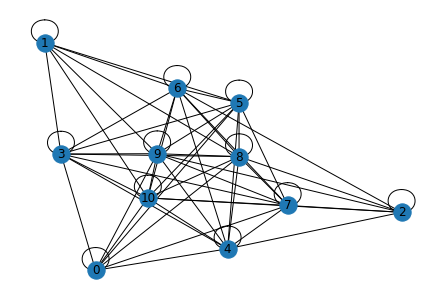

In [36]:
G = nx.from_numpy_matrix(Q)
nx.draw(G, with_labels=True)


Let's define a QUBO model and then solve it using DWaves code for complete enumeration and simulated annealing (eventually with Quantum annealiing too!).

In [37]:
model = dimod.BinaryQuadraticModel.from_qubo(Q, offset=cQ)

Since the problem is relatively small (11 variables, $2^{11}=2048$ combinations), we can afford to enumerate all the solutions.

In [38]:
exactSampler = dimod.reference.samplers.ExactSolver()
exactSamples = exactSampler.sample(model)

In [39]:
# Some useful functions to get plots
def plot_enumerate(results, title=None):

    plt.figure()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by='energy')]
    
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    plt.title(str(title))
    print("minimum energy:", min(energies))

def plot_samples(results, title=None):
    plt.figure()
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    counts = Counter(samples)
    total = len(samples)
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xticks(rotation=80)
    plt.ylabel('Probabilities')
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))


def plot_energies(results, title=None, skip=1):
    # skip parameter given to avoid putting all xlabels
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    ax = df.plot(kind='bar', legend=None)

    plt.xlabel('Energy')
    plt.ylabel('Probabilities')
    # Plot only a subset of xlabels (every skip steps)
    ax.set_xticklabels([t if not i%skip else "" for i,t in enumerate(ax.get_xticklabels())])
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))

minimum energy: 5.0


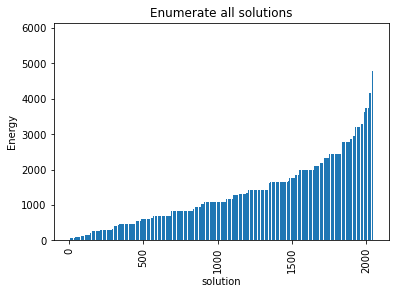

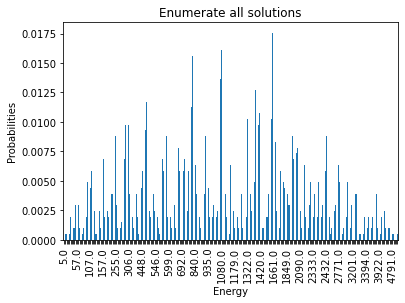

minimum energy: 5.0


In [40]:
plot_enumerate(exactSamples, title='Enumerate all solutions')
plot_energies(exactSamples, title='Enumerate all solutions', skip=10)

Let's now solve this QUBO via traditional Integer Programming.

In [41]:
# We do not need to worry about the tranformation to QUBO since dimod takes care of it
Q, c = model.to_qubo()

# Define the model
model_pyo = pyo.ConcreteModel(name='QUBO example as an IP, 47-779/785 QuIPML')

I = range(len(model))
J = range(len(model))
#Define the original variables
model_pyo.x = pyo.Var(I, domain=pyo.Binary)
# Define the edges variables
model_pyo.y = pyo.Var(I, J, domain=pyo.Binary)

obj_expr = c

# add model constraints
model_pyo.c1 = pyo.ConstraintList()
model_pyo.c2 = pyo.ConstraintList()
model_pyo.c3 = pyo.ConstraintList()
for (i,j) in Q.keys():
    if i != j:
        model_pyo.c1.add(model_pyo.y[i,j] >= model_pyo.x[i] + model_pyo.x[j] - 1)
        model_pyo.c2.add(model_pyo.y[i,j] <= model_pyo.x[i])
        model_pyo.c3.add(model_pyo.y[i,j] <= model_pyo.x[j])
        obj_expr += Q[i,j]*model_pyo.y[i,j]
    else:
        obj_expr += Q[i,j]*model_pyo.x[i]

# Define the objective function
model_pyo.objective = pyo.Objective(expr = obj_expr, sense=pyo.minimize)
# Print the model
model_pyo.display()

Model 'QUBO example as an IP, 47-779/785 QuIPML'

  Variables:
    x : Size=11, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 :  None :     1 : False :  True : Binary
          8 :     0 :  None :     1 : False :  True : Binary
          9 :     0 :  None :     1 : False :  True : Binary
         10 :     0 :  None :     1 : False :  True : Binary
    y : Size=121, Index=y_index
        Key      : Lower : Value : Upper : Fixed : Stale : Domain
          (0, 0) :     0 :  None :     1 : False :  True : Binary
          

Let's install the MIP solver GLPK

In [42]:
# Let's install the LP/MIP solvers GLPK and CBC
if IN_COLAB:
    !apt-get install -y -qq glpk-utils

In [43]:
# Define the solver GLPK
if IN_COLAB:
    opt_glpk = pyo.SolverFactory('glpk', executable='/usr/bin/glpsol')
else:
    opt_glpk = pyo.SolverFactory('glpk')
# Here we could use another solver, e.g. gurobi or cplex
# opt_gurobi = pyo.SolverFactory('gurobi')

In [44]:
# We obtain the solution with GLPK
result_obj = opt_glpk.solve(model_pyo, tee=False)
model_pyo.display()

Model 'QUBO example as an IP, 47-779/785 QuIPML'

  Variables:
    x : Size=11, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :     1 : False : False : Binary
          1 :     0 :   0.0 :     1 : False : False : Binary
          2 :     0 :   0.0 :     1 : False : False : Binary
          3 :     0 :   0.0 :     1 : False : False : Binary
          4 :     0 :   0.0 :     1 : False : False : Binary
          5 :     0 :   0.0 :     1 : False : False : Binary
          6 :     0 :   0.0 :     1 : False : False : Binary
          7 :     0 :   0.0 :     1 : False : False : Binary
          8 :     0 :   1.0 :     1 : False : False : Binary
          9 :     0 :   0.0 :     1 : False : False : Binary
         10 :     0 :   0.0 :     1 : False : False : Binary
    y : Size=121, Index=y_index
        Key      : Lower : Value : Upper : Fixed : Stale : Domain
          (0, 0) :     0 :  None :     1 : False :  True : Binary
          

We observe that the optimal solution of this problem is $x_{8} = 1, 0$ otherwise, leading to an objective of $5$. Notice that this problem has a degenerate optimal solution given that $x_{10} = 1, 0$ otherwise also leads to the same solution.

## Ising model
This notebook will explain the basics of the Ising model. In order to implement the different Ising Models we will use D-Wave's packages **[dimod](https://github.com/dwavesystems/dimod)** and **[neal](https://github.com/dwavesystems/dwave-neal)**, for defining the Ising model and solving it with simulated annealing, respectively. When posing the problems as Integer programs, we will model using **[Pyomo](http://www.pyomo.org/)**, an open-source Python package, which provides a flexible access to different solvers and a general modeling framework for linear and nonlinear integer programs.
The examples solved here will make use of open-source solver **[GLPK](https://www.gnu.org/software/glpk/)** for mixed-integer linear programming.

#### Problem statement
We pose the Ising problem as the following optimization problem:
$$
\min_{\sigma \in \{ -1,+1 \}^n} H(\sigma) =\min_{\sigma \in \{ -1,+1 \}^n} \sum_{(ij) \in E(G)} J_{ij}\sigma_i\sigma_j + \sum_{i \in V(G)}h_i\sigma_i + c_I
$$
where we optimize over spins $\sigma \in \{ -1,+1 \}^n$, on a constrained graph $G(V,E)$, where the quadratic coefficients are $J_{ij}$ and the linear coefficients are $h_i$. We also include an arbitrary offset of the Ising model $c_I$.

### Example
Suppose we have an Ising model defined from
$$
J_{0, 3}=24.0,J_{0, 4}=24.0,J_{0, 5}=24.0,J_{0, 7}=24.0,J_{0, 8}=24.0,J_{0, 9}=24.0,J_{0, 10}=24.0,\\
J_{1, 3}=24.0,J_{1, 5}=24.0,J_{1, 6}=24.0,J_{1, 8}=24.0,J_{1, 9}=24.0,J_{1, 10}=24.0,\\
J_{2, 4}=24.0,J_{2, 6}=24.0,J_{2, 7}=24.0,J_{2, 8}=24.0,J_{2, 9}=24.0,J_{2, 10}=24.0,\\
J_{3, 4}=24.0,J_{3, 5}=48.0,J_{3, 6}=24.0,J_{3, 7}=24.0,J_{3, 8}=48.0,J_{3, 9}=48.0,J_{3, 10}=48.0,\\
J_{4, 5}=24.0,J_{4, 6}=24.0,J_{4, 7}=48.0,J_{4, 8}=48.0,J_{4, 9}=48.0,J_{4, 10}=48.0,\\
J_{5, 6}=24.0,J_{5, 7}=24.0,J_{5, 8}=48.0,J_{5, 9}=48.0,J_{5, 10}=48.0,\\
J_{6, 7}=24.0,J_{6, 8}=48.0,J_{6, 9}=48.0,J_{6, 10}=48.0,\\
J_{7, 8}=48.0,J_{7, 9}=48.0,J_{7, 10}=48.0,\\
J_{8, 9}=72.0,J_{8, 10}=72.0,\\
J_{9, 10}=72.0 \\
J = \begin{bmatrix}
0 & 0 & 0 & 24 & 24 & 24 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 24 & 0 & 24 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 0 & 24 & 0 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 0 & 24 & 48 & 24 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 24 & 24 & 48 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 24 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 72 & 72\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 72\\
\end{bmatrix} \\
h^\top = [145.0,122.0,122.0,266.0,266.0,266.0,242.5,266.0,386.5,387.0,386.5] \\
c_I = 1319.5
$$
Let's solve this problem

In [45]:
# These could also be simple lists and numpy matrices
h = {0: 145.0, 1: 122.0, 2: 122.0, 3: 266.0, 4: 266.0, 5: 266.0, 6: 242.5, 7: 266.0, 8: 386.5, 9: 387.0, 10: 386.5}
J = {(0, 3): 24.0, (0, 4): 24.0, (0, 5): 24.0, (0, 7): 24.0, (0, 8): 24.0, (0, 9): 24.0, (0, 10): 24.0, (1, 3): 24.0, (1, 5): 24.0, (1, 6): 24.0, (1, 8): 24.0, (1, 9): 24.0, (1, 10): 24.0, (2, 4): 24.0, (2, 6): 24.0, (2, 7): 24.0, (2, 8): 24.0, (2, 9): 24.0, (2, 10): 24.0, (3, 4): 24.0, (3, 5): 48.0, (3, 6): 24.0, (3, 7): 24.0, (3, 8): 48.0, (3, 9): 48.0, (3, 10): 48.0, (4, 5): 24.0, (4, 6): 24.0, (4, 7): 48.0, (4, 8): 48.0, (4, 9): 48.0, (4, 10): 48.0, (5, 6): 24.0, (5, 7): 24.0, (5, 8): 48.0, (5, 9): 48.0, (5, 10): 48.0, (6, 7): 24.0, (6, 8): 48.0, (6, 9): 48.0, (6, 10): 48.0, (7, 8): 48.0, (7, 9): 48.0, (7, 10): 48.0, (8, 9): 72.0, (8, 10): 72.0, (9, 10): 72.0}
cI = 1319.5

model_ising = dimod.BinaryQuadraticModel.from_ising(h, J, offset=cI)



Since the problem is relatively small (11 variables, $2^{11}=2048$ combinations), we can afford to enumerate all the solutions.

In [46]:
exactSamples = exactSampler.sample(model_ising)

minimum energy: 5.0


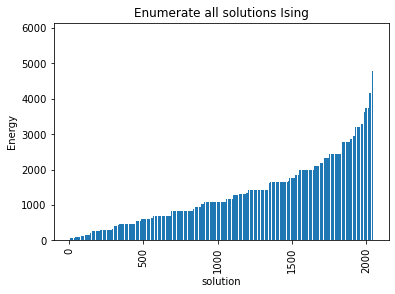

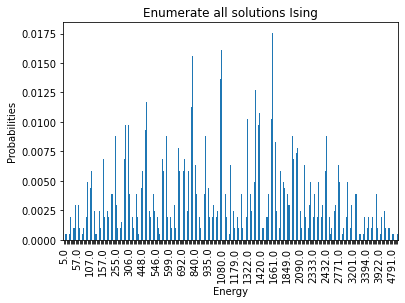

minimum energy: 5.0


In [47]:
plot_enumerate(exactSamples, title='Enumerate all solutions Ising')
plot_energies(exactSamples, title='Enumerate all solutions Ising', skip=10)

Let's now solve this Ising Model via traditional Integer Programming.

In [48]:
# We do not need to worry about the tranformation from Ising to QUBO since dimod takes care of it
Q, c = model_ising.to_qubo()

# Define the model
model_ising_pyo = pyo.ConcreteModel(name='Ising example as an IP, 47-779/785 QuIPML')

I = range(len(h))
J = range(len(h))
#Define the original variables
model_ising_pyo.x = pyo.Var(I, domain=pyo.Binary)
# Define the edges variables
model_ising_pyo.y = pyo.Var(I, J, domain=pyo.Binary)

obj_expr = c

# add model constraints
model_ising_pyo.c1 = pyo.ConstraintList()
model_ising_pyo.c2 = pyo.ConstraintList()
model_ising_pyo.c3 = pyo.ConstraintList()
for (i,j) in Q.keys():
    if i != j:
        model_ising_pyo.c1.add(model_ising_pyo.y[i,j] >= model_ising_pyo.x[i] + model_ising_pyo.x[j] - 1)
        model_ising_pyo.c2.add(model_ising_pyo.y[i,j] <= model_ising_pyo.x[i])
        model_ising_pyo.c3.add(model_ising_pyo.y[i,j] <= model_ising_pyo.x[j])
        obj_expr += Q[i,j]*model_ising_pyo.y[i,j]
    else:
        obj_expr += Q[i,j]*model_ising_pyo.x[i]

# Define the objective function
model_ising_pyo.objective = pyo.Objective(expr = obj_expr, sense=pyo.minimize)
# Print the model
model_ising_pyo.display()

Model 'Ising example as an IP, 47-779/785 QuIPML'

  Variables:
    x : Size=11, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 :  None :     1 : False :  True : Binary
          8 :     0 :  None :     1 : False :  True : Binary
          9 :     0 :  None :     1 : False :  True : Binary
         10 :     0 :  None :     1 : False :  True : Binary
    y : Size=121, Index=y_index
        Key      : Lower : Value : Upper : Fixed : Stale : Domain
          (0, 0) :     0 :  None :     1 : False :  True : Binary
         

In [49]:
# We obtain the solution with GLPK
result_obj = opt_glpk.solve(model_ising_pyo, tee=False)
model_ising_pyo.display()

Model 'Ising example as an IP, 47-779/785 QuIPML'

  Variables:
    x : Size=11, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :     1 : False : False : Binary
          1 :     0 :   0.0 :     1 : False : False : Binary
          2 :     0 :   0.0 :     1 : False : False : Binary
          3 :     0 :   0.0 :     1 : False : False : Binary
          4 :     0 :   0.0 :     1 : False : False : Binary
          5 :     0 :   0.0 :     1 : False : False : Binary
          6 :     0 :   0.0 :     1 : False : False : Binary
          7 :     0 :   0.0 :     1 : False : False : Binary
          8 :     0 :   0.0 :     1 : False : False : Binary
          9 :     0 :   0.0 :     1 : False : False : Binary
         10 :     0 :   1.0 :     1 : False : False : Binary
    y : Size=121, Index=y_index
        Key      : Lower : Value : Upper : Fixed : Stale : Domain
          (0, 0) :     0 :  None :     1 : False :  True : Binary
         

We observe that the optimal solution of this problem is $x_{10} = 1, 0$ otherwise, leading to an objective of $5$. Notice that this problem has a degenerate optimal solution given that $x_8 = 1, 0$ otherwise also leads to the same solution.

## Let's go back to the slides

Let's now solve the QUBO problem using Simulated Annealing

In [50]:
simAnnSampler = neal.SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(model, num_reads=1000)


minimum energy: 5.0


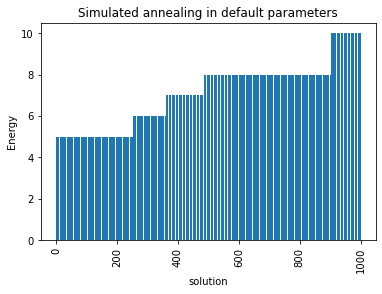

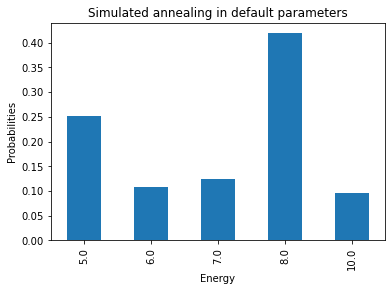

minimum energy: 5.0


In [51]:
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')

Notice that this is the same example we have been solving earlier (via Integer Programming in the Quiz 1 and Ising model above).

## Let's go back to the slides

Let's solve the graph coloring problem in the slides using QUBO.

#### Vertex $k$-coloring of graphs 
Given a graph $\mathcal{G}(V, E)$, where $V$ is the set of vertices and $E$ is the set of edges of $\mathcal{G}$, and a positive integer $k$, we ask if it is possible to assign a color to every vertex from $V$, such that adjacent vertices have different colors assigned.

$\mathcal{G}(V, E)$ has 12 vertices and 23 edges. We ask if the graph is $3$–colorable. Let’s first encode $V$ and $E$ using Python’s built–in data structures:

This second tutorial is heavily inspired in D-Wave's Map coloring of Canada found **[here](https://docs.ocean.dwavesys.com/en/stable/examples/map_coloring.html)**.

In [52]:
# Let's install with dimod and neal
if IN_COLAB:
    !pip install dwavebinarycsp
    !pip install dwavebinarycsp[maxgap]
    !pip install dwavebinarycsp[mip]

import dwavebinarycsp

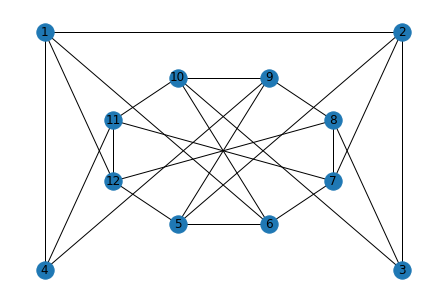

In [53]:
V = range(1, 12+1)
E = [(1,2),(2,3),(1,4),(1,6),(1,12),(2,5),(2,7),(3,8),(3,10),(4,11),(4,9),(5,6),(6,7),(7,8),(8,9),(9,10),(10,11),(11,12),(5,12),(5,9),(6,10),(7,11),(8,12)]
layout = {i: [np.cos((2*i+1)*np.pi/8),np.sin((2*i+1)*np.pi/8)] for i in np.arange(5,13)}
layout[1] = [-1.5,1.5]
layout[2] = [1.5,1.5]
layout[3] = [1.5,-1.5]
layout[4] = [-1.5,-1.5]
G = nx.Graph()
G.add_edges_from(E)
nx.draw(G, with_labels=True, pos=layout)

In [54]:
# Function for the constraint that two nodes with a shared edge not both select
# one color
def not_both_1(v, u):
    return not (v and u)

# Valid configurations for the constraint that each node select a single color, in this case we want to use 3 colors
one_color_configurations = {(0, 0, 1), (0, 1, 0), (1, 0, 0)}
colors = len(one_color_configurations)

# Create a binary constraint satisfaction problem
csp = dwavebinarycsp.ConstraintSatisfactionProblem(dwavebinarycsp.BINARY)

# Add constraint that each node select a single color
for node in V:
    variables = ['x'+str(node)+','+str(i) for i in range(colors)]
    csp.add_constraint(one_color_configurations, variables)

# Add constraint that each pair of nodes with a shared edge not both select one color
for edge in E:
    v, u = edge
    for i in range(colors):
        variables = ['x'+str(v)+','+str(i), 'x'+str(u)+','+str(i)]
        csp.add_constraint(not_both_1, variables)

Defining the Binary Quandratic model (QUBO) using the CSP library we have:

In [55]:
bqm = dwavebinarycsp.stitch(csp)

In [56]:
simAnnSamples = simAnnSampler.sample(bqm, num_reads=1000)


minimum energy: 4.5434680373546144e-07


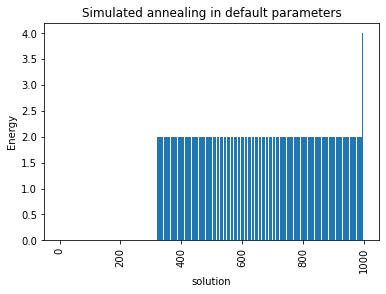

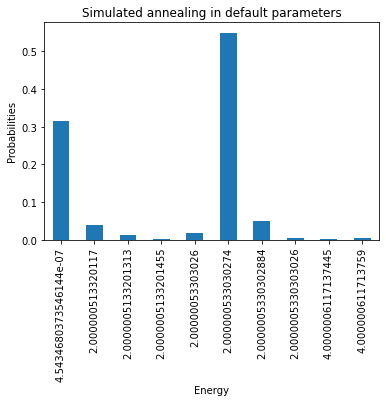

minimum energy: 4.5434680373546144e-07


In [57]:
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')

Because of precision issues in the translation to BQM, we obtain very tiny coefficeints that should be zero. In any case, since this is a constraint satisfaction problem, any of the solutions with energy ~0 is a valid coloring.

In [58]:
# Check that a good solution was found
sample = simAnnSamples.first.sample     # doctest: +SKIP
if not csp.check(sample):           # doctest: +SKIP
        print("Failed to color map. Try sampling again.")
else:
        print(sample)

{'x1,0': 0, 'x1,1': 0, 'x1,2': 1, 'x10,0': 0, 'x10,1': 0, 'x10,2': 1, 'x11,0': 0, 'x11,1': 1, 'x11,2': 0, 'x12,0': 1, 'x12,1': 0, 'x12,2': 0, 'x2,0': 0, 'x2,1': 1, 'x2,2': 0, 'x3,0': 1, 'x3,1': 0, 'x3,2': 0, 'x4,0': 1, 'x4,1': 0, 'x4,2': 0, 'x5,0': 0, 'x5,1': 0, 'x5,2': 1, 'x6,0': 0, 'x6,1': 1, 'x6,2': 0, 'x7,0': 1, 'x7,1': 0, 'x7,2': 0, 'x8,0': 0, 'x8,1': 0, 'x8,2': 1, 'x9,0': 0, 'x9,1': 1, 'x9,2': 0}


In [59]:
# Function that plots a returned sample
def plot_map(sample):
    # Translate from binary to integer color representation
    color_map = {}
    for node in V:
          for i in range(colors):
            if sample['x'+str(node)+','+str(i)]:
                color_map[node] = i
    # Plot the sample with color-coded nodes
    node_colors = [color_map.get(node) for node in G.nodes()]
    nx.draw(G, with_labels=True, pos=layout, node_color=node_colors)
    plt.show()

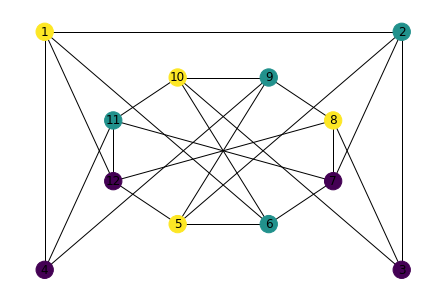

In [60]:
plot_map(sample)